<a href="https://colab.research.google.com/github/AeneasWeiChiHsu/AeneasWeiChiHsu/blob/main/Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

我們這邊用 [Denoising Diffusion Probabilistic Model](https://keras.io/examples/generative/ddpm/) Keras 的教材。

我們來做Diffusion Model。

理論上會很難做。

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Requires TensorFlow >=2.11 for the GroupNormalization layer.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Hyperparameters

In [3]:
batch_size = 32
num_epochs = 1  # Just for the sake of demonstration


total_timesteps = 1000
norm_groups = 8  # Number of groups used in GroupNormalization layer

learning_rate = 2e-4

img_size = 64
img_channels = 3

clip_min = -1.0
clip_max = 1.0

first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]

has_attention = [False, False, True, True]
num_res_blocks = 2  # Number of residual blocks

dataset_name = "oxford_flowers102"
splits = ["train"]

In [4]:
# Load the dataset
(ds,) = tfds.load(dataset_name, split=splits, with_info=False, shuffle_files=True)


def augment(img):
    """Flips an image left/right randomly."""
    return tf.image.random_flip_left_right(img)


def resize_and_rescale(img, size):
    """Resize the image to the desired size first and then
    rescale the pixel values in the range [-1.0, 1.0].

    Args:
        img: Image tensor
        size: Desired image size for resizing
    Returns:
        Resized and rescaled image tensor
    """

    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    crop_size = tf.minimum(height, width)

    img = tf.image.crop_to_bounding_box(
        img,
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # Resize
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, size=size, antialias=True)

    # Rescale the pixel values
    img = img / 127.5 - 1.0
    img = tf.clip_by_value(img, clip_min, clip_max)
    return img


def train_preprocessing(x):
    img = x["image"]
    img = resize_and_rescale(img, size=(img_size, img_size))
    img = augment(img)
    return img


train_ds = (
    ds.map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .shuffle(batch_size * 2)
    .prefetch(tf.data.AUTOTUNE)
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.E19Q8K_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.E19Q8K_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.E19Q8K_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


# Gaussian Diffusion Utilities

We define the forward process and the reverse process as a separate utility. Most of the code in this utility has been borrowed from the original implementation with some slight modifications.

⬆️是原文

我們翻譯成白話就是：


1.   Forward 一個部分
2.   Backward 一個部分

上面這兩個部分要自己來做（或者說這個是標準做法）



In [6]:
class GaussianDiffusion:
    """Gaussian diffusion utility.

    Args:
        beta_start: Start value of the scheduled variance
        beta_end: End value of the scheduled variance
        timesteps: Number of time steps in the forward process
    """

    def __init__(
        self,
        beta_start=1e-4,
        beta_end=0.02,
        timesteps=1000,
        clip_min=-1.0,
        clip_max=1.0,
    ):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        # Define the linear variance schedule
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Using float64 for better precision
        )
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = tf.constant(
            np.sqrt(alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_one_minus_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.log_one_minus_alphas_cumprod = tf.constant(
            np.log(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_recip_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_recipm1_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32
        )

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = tf.constant(
            np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
        )

        self.posterior_mean_coef1 = tf.constant(
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

    def _extract(self, a, t, x_shape):
        """Extract some coefficients at specified timesteps,
        then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.

        Args:
            a: Tensor to extract from
            t: Timestep for which the coefficients are to be extracted
            x_shape: Shape of the current batched samples
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        """Extracts the mean, and the variance at current timestep.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(
            self.log_one_minus_alphas_cumprod, t, x_start_shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        """Diffuse the data.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
            noise: Gaussian noise to be added at the current timestep
        Returns:
            Diffused samples at timestep `t`
        """
        x_start_shape = tf.shape(x_start)
        return (
            self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_start)) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)
            * noise
        )

    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """Compute the mean and variance of the diffusion
        posterior q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Stating point(sample) for the posterior computation
            x_t: Sample at timestep `t`
            t: Current timestep
        Returns:
            Posterior mean and variance at current timestep
        """

        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t_shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Sample from the diffusion model.

        Args:
            pred_noise: Noise predicted by the diffusion model
            x: Samples at a given timestep for which the noise was predicted
            t: Current timestep
            clip_denoised (bool): Whether to clip the predicted noise
                within the specified range or not.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t, clip_denoised=clip_denoised
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # No noise when t == 0
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise


# Network Architecture

U-Net, originally developed for semantic segmentation, is an architecture that is widely used for implementing diffusion models but with some slight modifications:


1.   The network accepts two inputs: Image and time step
2.   Self-attention between the convolution blocks once we reach a specific resolution (16x16 in the paper)
3.   Group Normalization instead of weight normalization

We implement most of the things as used in the original paper. We use the swish activation function throughout the network. We use the variance scaling kernel initializer.

The only difference here is the number of groups used for the GroupNormalization layer. For the flowers dataset, we found that a value of groups=8 produces better results compared to the default value of groups=32. Dropout is optional and should be used where chances of over fitting is high. In the paper, the authors used dropout only when training on CIFAR10.

⬆️是原文

我們翻譯一下：
1. 整個網路要圖片跟時間步驟。
2. Self-attention 會需要用到。
3. Group Normalization 會用到。

這邊很現實層面的問題是這樣：如果你不會 Self attention mechanism （在LLM裡面）那麼你就不會知道這邊是怎麼 Self-Attention的。

In [7]:
# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )


class AttentionBlock(layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
        proj = self.proj(proj)
        return inputs + proj


class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb


def ResidualBlock(width, groups=8, activation_fn=keras.activations.swish):
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(
                width, kernel_size=1, kernel_initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[
            :, None, None, :
        ]

        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)

        x = layers.Add()([x, temb])
        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0)
        )(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownSample(width):
    def apply(x):
        x = layers.Conv2D(
            width,
            kernel_size=3,
            strides=2,
            padding="same",
            kernel_initializer=kernel_init(1.0),
        )(x)
        return x

    return apply


def UpSample(width, interpolation="nearest"):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation=interpolation)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)
        return x

    return apply


def TimeMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        temb = layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb

    return apply


def build_model(
    img_size,
    img_channels,
    widths,
    has_attention,
    num_res_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation_fn=keras.activations.swish,
):
    image_input = layers.Input(
        shape=(img_size, img_size, img_channels), name="image_input"
    )
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")

    x = layers.Conv2D(
        first_conv_channels,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=kernel_init(1.0),
    )(image_input)

    temb = TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)

        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )
    x = AttentionBlock(widths[-1], groups=norm_groups)(x)
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)

        if i != 0:
            x = UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(3, (3, 3), padding="same", kernel_initializer=kernel_init(0.0))(x)
    return keras.Model([image_input, time_input], x, name="unet")

# Training
We follow the same setup for training the diffusion model as described in the paper. We use Adam optimizer with a learning rate of 2e-4. We use EMA on model parameters with a decay factor of 0.999. We treat our model as noise prediction network i.e. at every training step, we input a batch of images and corresponding time steps to our UNet, and the network outputs the noise as predictions.

The only difference is that we aren't using the Kernel Inception Distance (KID) or Frechet Inception Distance (FID) for evaluating the quality of generated samples during training. This is because both these metrics are compute heavy and are skipped for the brevity of implementation.

**Note: ** We are using mean squared error as the loss function which is aligned with the paper, and theoretically makes sense. In practice, though, it is also common to use mean absolute error or Huber loss as the loss function.

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.7793

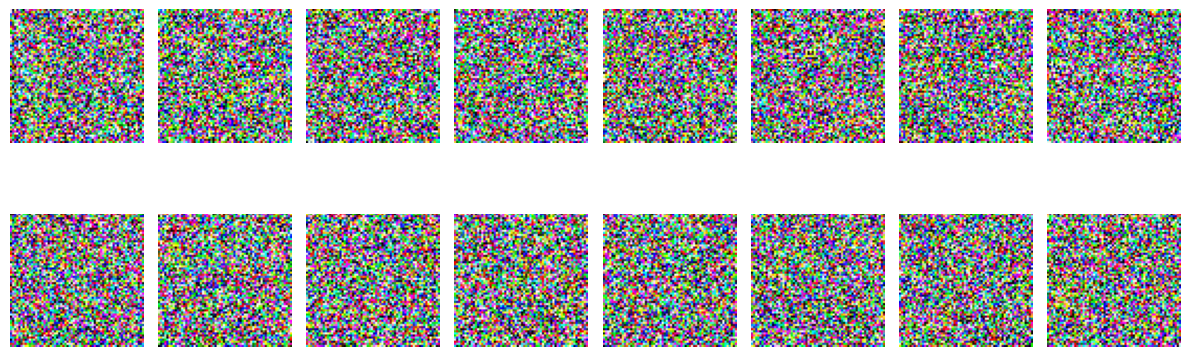

31/31 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - loss: 0.7549 


In [8]:
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, images):
        # 1. Get the batch size
        batch_size = tf.shape(images)[0]

        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64
        )

        with tf.GradientTape() as tape:
            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)

            # 4. Diffuse the images with noise
            images_t = self.gdf_util.q_sample(images, t, noise)

            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t], training=True)

            # 6. Calculate the loss
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Updates the weight values for the network with EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        # 10. Return loss values
        return {"loss": loss}

    def generate_images(self, num_images=16):
        # 1. Randomly sample noise (starting point for reverse process)
        samples = tf.random.normal(
            shape=(num_images, img_size, img_size, img_channels), dtype=tf.float32
        )
        # 2. Sample from the model iteratively
        for t in reversed(range(0, self.timesteps)):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict(
                [samples, tt], verbose=0, batch_size=num_images
            )
            samples = self.gdf_util.p_sample(
                pred_noise, samples, tt, clip_denoised=True
            )
        # 3. Return generated samples
        return samples

    def plot_images(
        self, epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12, 5)
    ):
        """Utility to plot images using the diffusion model during training."""
        generated_samples = self.generate_images(num_images=num_rows * num_cols)
        generated_samples = (
            tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
            .numpy()
            .astype(np.uint8)
        )

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()


# Build the unet model
network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)
ema_network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)
ema_network.set_weights(network.get_weights())  # Initially the weights are the same

# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

# Get the model
model = DiffusionModel(
    network=network,
    ema_network=ema_network,
    gdf_util=gdf_util,
    timesteps=total_timesteps,
)

# Compile the model
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
)

# Train the model
model.fit(
    train_ds,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images)],
)

# Tutorial

[Creating Simple Diffusion Model From Scratch in TensorFlow](https://medium.com/@keshavarorasci/creating-simple-diffusion-model-from-scratch-in-tensorflow-eaf1e7a8c3a1)

⬆️我去找了這個，看起來比較友善。
這邊在教我們怎麼做Diffusion model，會比前上面那個來的更加友善一些。

⬆️是友善很多的那種。我們先來學基本架構，然後我們在自己練習做一版自己的。

➡️Diffusion Model 的教學影片：https://www.youtube.com/watch?v=fbLgFrlTnGU

這邊的邏輯是這樣：

1️⃣ 從乾淨的圖片出發（大家都這樣）
2️⃣ 加料。就是增加一點噪音。
3️⃣ 訓練模型預測沒有噪音的圖片（簡單來說就是去噪音）
4️⃣ 逐步增加噪音強度
5️⃣ 持續做，直到模型可以每一步還原回去。

Medium教學上面，是這樣說的：

1️⃣Start with a clean image.
2️⃣Add a little noise.
3️⃣Teach the model to predict the image before the noise was added.
4️⃣Gradually increase the amount of noise and repeat the training.
5️⃣Keep going until the model can predict what any noisy image should look like at every step.

總結來說，這個跟GAN的目標很像，就是從雜訊中生出新東西，但是我們想要的事情是，比GAN的互相對抗來的更穩定一些。

一天的時間很快就過去了。

In [51]:
# Loading Data: MNIST
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [2]:
import tensorflow as tf
# ✅ 換成 CIFAR-10
cifar = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar.load_data()

# ✅ 正規化到 [0, 1] 並轉成 float32
x_train = X_train.astype('float32') / 255.0

# ✅ 沒有灰階，所以不用加 newaxis
# ❗️UNet 輸入要支援 3 channels（in_channels = 3）

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


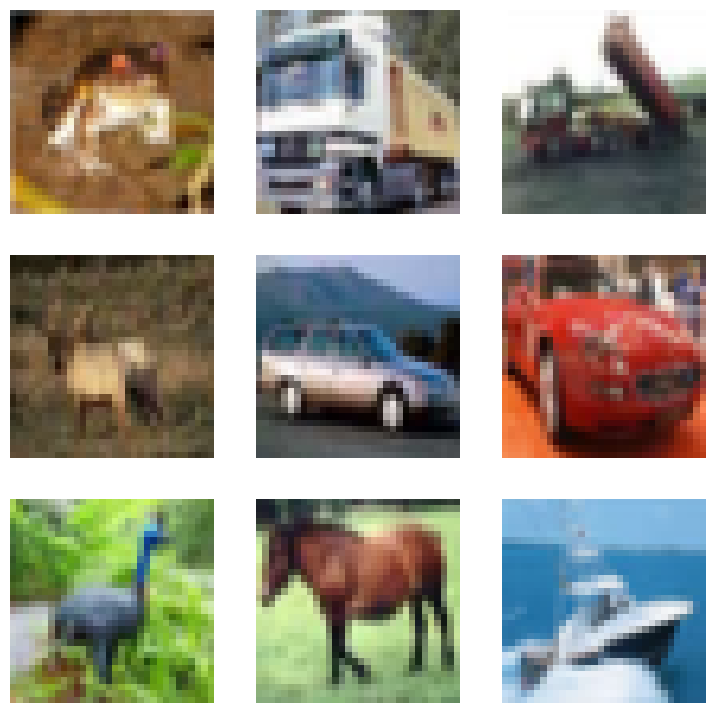

In [3]:
import matplotlib.pyplot as plt

# Plot
def normalisation(img):
    img = img/255.0
    return img

def examples(x):
    plt.figure(figsize=(9, 9))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = normalisation(x[i])
        plt.imshow(img, cmap='gray')
        plt.axis('off')

examples(X_train)

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
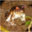

In [5]:
X_train[0]

In [6]:
# Our noise function in simple terms
def corrupt(x, noise_amount):
    noise_amount = tf.reshape(noise_amount, [-1, 1, 1, 1])
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0,dtype=tf.float32)
    return x + noise_amount * noise


In [ ]:
# 定義對應的噪音程度（0=noise-free, 1=全噪）
noise_levels = tf.constant([0.0, 0.25, 0.5, 0.75, 1.0], dtype=tf.float32)

# 選擇測試圖片數量
num_test_images = 5

# 從測試集中選擇圖片
test_images = X_test[:num_test_images]
test_images = tf.expand_dims(test_images, axis=-1) # 將圖片轉換成 (num_test_images, 28, 28, 1) 的形狀
test_images = tf.cast(test_images, dtype=tf.float32) / 255.0 # 正規化圖片

# 加噪，並將每個噪音程度的結果儲存到一個 list 中
noised_images_list = [corrupt(test_images, noise_level) for noise_level in noise_levels]

# 顯示圖片
plt.figure(figsize=(15, 3))
for i in range(num_test_images):
    plt.subplot(1, num_test_images, i+1)
    plt.imshow(noised_images_list[i][0, ..., 0], cmap='gray')  # 顯示第一張圖片的灰階圖像
    plt.title(f"noise: {noise_levels[i].numpy():.2f}")
    plt.axis('off')
plt.suptitle("Corrupted MNIST samples with different noise levels")
plt.show()

# U Net

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Reshape
from tensorflow.keras import Model

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Reshape, Activation # Import Activation
from tensorflow.keras import Model, Sequential # Import Sequential
from tensorflow.keras.layers import Concatenate # Import Concatenate

# ✅ 獨立的 timestep embedding 函數
# 這邊模仿 Transformer 的 Positional Encoding
def get_timestep_embedding(timesteps, dim):
    half_dim = dim // 2
    emb = tf.math.log(10000.0) / (tf.cast(half_dim, tf.float32) - 1)
    emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
    emb = tf.cast(timesteps, tf.float32)[:, None] * emb[None, :]
    emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
    return emb

# ✅ 改良版 UNet 支援時間步嵌入
class BasicUNet(Model):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=128):
        super().__init__()
        # 32*32 or 28*28 直接改這邊
        self.time_dense = Dense(32 * 32, activation='relu')
        self.reshape = Reshape((32, 32, 1))

        # Down path
        self.down_layers = [
            Conv2D(32, kernel_size=5, padding='same'),
            Conv2D(64, kernel_size=5, padding='same'),
            Conv2D(64, kernel_size=5, padding='same')
        ]
        self.downscale = MaxPooling2D(pool_size=(2, 2))

        # Up path
        self.up_layers = [
            Conv2D(64, kernel_size=5, padding='same'),
            Conv2D(32, kernel_size=5, padding='same'),
            Conv2D(out_channels, kernel_size=5, padding='same')
        ]
        self.upscale = UpSampling2D(size=(2, 2))

        self.act = tf.keras.activations.relu

    def call(self, inputs, training=False):
        x, t_emb = inputs  # 👈 傳進來的 t_emb 是外部處理好的 timestep embedding

        # Expand and add time embedding
        t_proj = self.time_dense(t_emb)
        t_proj = self.reshape(t_proj)
        x = x + t_proj  # broadcasting 加進去

        skips = []
        # Downsampling
        for i, layer in enumerate(self.down_layers):
            x = layer(x)
            x = self.act(x)
            if i < 2:
                skips.append(x)
                x = self.downscale(x)

        # Upsampling
        for i, layer in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                skip = skips.pop()
                x = x + skip
            x = layer(x)
            if i < len(self.up_layers) - 1:
                x = self.act(x)

        return x

# 升級版
class DeepUNet(Model):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=128):
        super().__init__()

        self.time_dense = Dense(32 * 32, activation='relu')
        self.reshape = Reshape((32, 32, 1))

        # Encoder
        self.down1 = self._conv_block(in_channels, 64)
        self.down2 = self._conv_block(64, 128)
        self.down3 = self._conv_block(128, 256)

        self.pool = MaxPooling2D(pool_size=(2, 2))

        # Decoder
        self.up1 = self._conv_block(256 + 128, 128)
        self.up2 = self._conv_block(128 + 64, 64)
        self.up3 = Conv2D(out_channels, kernel_size=3, padding='same')

        self.upsample = UpSampling2D(size=(2, 2))

    def _conv_block(self, in_channels, out_channels):
        return Sequential([
            Conv2D(out_channels, kernel_size=3, padding='same'),
            Activation('relu'),
            Conv2D(out_channels, kernel_size=3, padding='same'),
            Activation('relu'),
        ])

    def call(self, inputs, training=False):
        x, t_emb = inputs
        t_proj = self.reshape(self.time_dense(t_emb))
        x = x + t_proj  # broadcast 加入時間資訊

        # Encoder
        x1 = self.down1(x)       # -> (28, 28, 64)
        x2 = self.down2(self.pool(x1))  # -> (14, 14, 128)
        x3 = self.down3(self.pool(x2))  # -> (7, 7, 256)

        # Decoder
        u1 = self.upsample(x3)
        u1 = Concatenate()([u1, x2])
        u1 = self.up1(u1)

        u2 = self.upsample(u1)
        u2 = Concatenate()([u2, x1])
        u2 = self.up2(u2)

        out = self.up3(u2)
        return out

In [6]:
# t → embedding vector (sinusoidal encoding)
# 將整數 time step t 映射成高維向量（如 128 維）
# 小頻率學細節、大頻率學長期趨勢。
# 這個是 positional encoding！
def get_timestep_embedding(timesteps, dim):
    half_dim = dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = tf.cast(tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb), dtype=tf.float32)
    emb = tf.cast(timesteps, dtype=tf.float32)[:, tf.newaxis] * emb[tf.newaxis, :]
    emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
    return emb  # shape = (batch, dim)


# 輸入：
# - timesteps: shape=(batch,), 每個 batch 的 timestep（例如 0~999）
# - dim: int，想要的嵌入維度（通常是 128）
#
# 輸出：
# - embeddings: shape=(batch, dim)，每個 timestep 對應的向量

In [7]:
# 建立 Noise Scheduler（β 時間表）
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return np.linspace(beta_start, beta_end, timesteps, dtype=np.float32)

In [8]:
from tqdm import tqdm
import numpy as np


In [ ]:
x_train = X_train.astype('float32') / 255.0

batch_size = 128
n_epochs = 100
learning_rate = 1e-3
# 計算 α、α_bar（必要的中介變數）

# ✅ Call linear_beta_schedule to define betas before using it
betas = linear_beta_schedule(timesteps=1000)  # Assuming 1000 timesteps

# 計算 α、α_bar（必要的中介變數）
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)  # [ᾱₜ] for each timestep


# Create a tf.data.Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,x_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# ✅ 加在這裡！建立 UNet 模型
# 這邊你可以試試看用BasicUNet或DeepUNet
# model = BasicUNet(in_channels=1, out_channels=1)
model = DeepUNet(in_channels=3, out_channels=3)

# Define loss and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Lists to store the loss history
losses = []

# Custom training loop
for epoch in range(n_epochs):
    epoch_losses = []
    print(f"Epoch {epoch+1}/{n_epochs}")

    # Step 雖然在 for loop 裡面，但是我們其實是沒有用到的。
    for step, (images, _) in enumerate(tqdm(train_dataset, desc=f"Training")):
        batch_size_current = tf.shape(images)[0]

        # 1. 隨機 timestep
        t = tf.random.uniform([batch_size_current], minval=0, maxval=1000, dtype=tf.int32)
        t_emb = get_timestep_embedding(t, 128)

        # 2. 加入噪音
        noise = tf.random.normal(tf.shape(images))

        alpha_bars_tf = tf.convert_to_tensor(alpha_bars)  # ← 先轉成 tensor 放 GPU

      # 根據每個 batch 的 timestep 拿對應的 ᾱₜ
        a_bar = tf.gather(alpha_bars_tf, t)  # shape = (batch,)
        a_bar = a_bar[:, None, None, None]   # reshape to broadcast

        # 來自原始論文的公式
        noisy_x = tf.sqrt(a_bar) * images + tf.sqrt(1.0 - a_bar) * noise

        with tf.GradientTape() as tape:
            pred_noise = model([noisy_x, t_emb], training=True)
            loss = loss_fn(noise, pred_noise)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_losses.append(loss.numpy())

    avg_loss = np.mean(epoch_losses)
    tqdm.write(f"Step {step} | Loss: {loss.numpy():.5f}")

    # ✅ 視覺化訓練成果
    fig, axes = plt.subplots(5, 3, figsize=(10, 6))
    for i in range(5):
        test_img = images[i:i+1]
        test_noisy = noisy_x[i:i+1]
        test_pred_noise = model([test_noisy, t_emb[i:i+1]], training=False)
        a_bar_test = tf.gather(alpha_bars_tf, t[i:i+1])
        a_bar_test = a_bar_test[:, None, None, None]
        test_denoised = (test_noisy - tf.sqrt(1.0 - a_bar_test) * test_pred_noise) / tf.sqrt(a_bar_test)

        axes[i, 0].imshow(test_img[0])
        axes[i, 1].imshow(test_noisy[0])
        axes[i, 2].imshow(tf.clip_by_value(test_denoised[0], 0.0, 1.0))
        for j in range(3): axes[i, j].axis('off')
    axes[0, 0].set_title("Original")
    axes[0, 1].set_title("Noisy")
    axes[0, 2].set_title("Denoised")
    plt.tight_layout()
    plt.show()

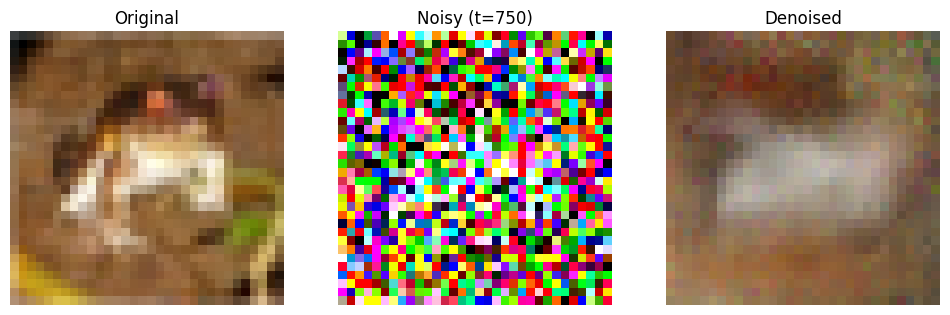

In [22]:
def show_denoising_example(model, x_sample, t_step, embedding_dim=128):
    t = tf.constant([t_step], dtype=tf.int32)
    t_emb = get_timestep_embedding(t, embedding_dim)

    noise = tf.random.normal(tf.shape(x_sample))
    noise_level = tf.cast(t, tf.float32)[:, None, None, None] / 1000.0
    noisy_image = x_sample + noise_level * noise

    pred_noise = model([noisy_image, t_emb], training=False)
    denoised = noisy_image - noise_level * pred_noise
    denoised = tf.clip_by_value(denoised, 0.0, 1.0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(x_sample[0])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_image[0])
    plt.title(f"Noisy (t={t_step})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(denoised[0])
    plt.title("Denoised")
    plt.axis("off")

    plt.show()

# 使用第一張圖片來展示效果
x_sample = x_train[None, 0]
show_denoising_example(model, x_sample, t_step=750)

In [23]:
# 建立 Noise Scheduler（β 時間表）
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return np.linspace(beta_start, beta_end, timesteps, dtype=np.float32)

T = 1000  # Total diffusion steps
betas = linear_beta_schedule(T)

# 計算 α、α_bar（必要的中介變數）
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)  # [ᾱₜ] for each timestep

# Sampling Loop（從純 noise denoise 成圖）
# 這是一個 inference 過程，不需要真實圖片。
def sample_ddpm(model, shape, betas, alpha_bars, num_steps=1000):
    img = tf.random.normal(shape)  # z_T ~ N(0,1)

    for t in reversed(range(num_steps)):
        alpha_bar_t = tf.constant(alpha_bars[t], dtype=tf.float32)
        alpha_t = tf.constant(1.0 - betas[t], dtype=tf.float32)
        beta_t = tf.constant(betas[t], dtype=tf.float32)

        t_tensor = tf.fill([shape[0]], t)
        t_emb = get_timestep_embedding(t_tensor, dim=128)

        pred_noise = model([img, t_emb], training=False)

        # Reconstruct image estimate from noise
        img = (1 / tf.sqrt(alpha_t)) * (
            img - (beta_t / tf.sqrt(1 - alpha_bar_t)) * pred_noise
        )

        if t > 0:
            noise = tf.random.normal(shape)
            img += tf.sqrt(beta_t) * noise  # add noise only if not the final step

    return tf.clip_by_value(img, 0.0, 1.0)


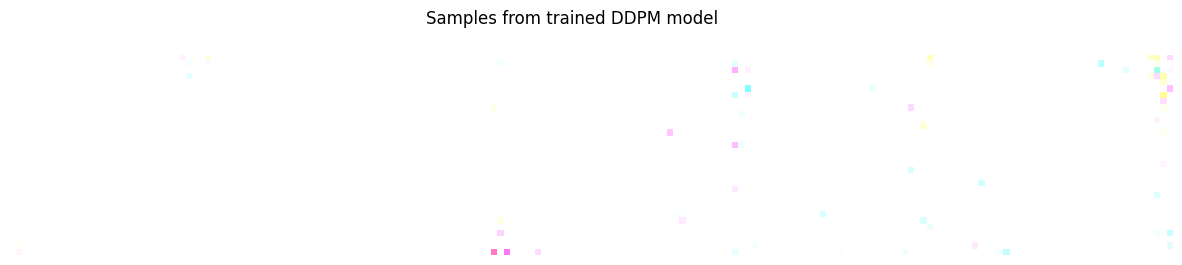

In [24]:
# 執行生成圖像
generated_imgs = sample_ddpm(model, shape=(5, 32, 32, 3), betas=betas, alpha_bars=alpha_bars)  # Change the shape here

# Plot
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(generated_imgs[i])
    plt.axis('off')
plt.suptitle("Samples from trained DDPM model")
plt.show()